*Luis Antonio Ortega Andrés   
Antonio Coín Castro*

In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, IBMQ, execute
from qiskit.visualization import plot_histogram

%matplotlib inline

# Load IBM account
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-11-27 14:18:16,842: Credentials are already in use. The existing account in the session will be replaced.


# Algoritmo de Bernstein-Vazirani

Estudiamos el enfoque cuántico del [algoritmo de Bernstein-Vazirani](https://en.wikipedia.org/wiki/Bernstein%E2%80%93Vazirani_algorithm).

## Planteamiento del problema

Consideramos un natural $n \in \mathbb{N}$ fijo y conocido, una cadena binaria $s \in \{0,1\}^n$ desconocida, y la aplicación (conocida)

$$
\begin{aligned}
f:\{0,1\}^n &\to \{0,1\}\\
x &\mapsto x\cdot s,
\end{aligned}
$$

donde $\cdot$ es el producto escalar bit a bit módulo 2. Es decir, si $s = s_0s_1,\dots,s_{n-1}$ y $x = x_0,x_1,\dots,x_{n-1}$, entonces

$$
x\cdot s = \sum_{i=0}^{n-1} x_is_i\, \bmod 2.
$$

Resolver el problema consiste en encontrar el valor de la cadena secreta $s$.

## Resolución clásica

El algoritmo clásico para resolver el problema se basa en la siguiente idea: dado un elemento $x^{(j)} \in \{0,1\}^n$ formado por todo $0$s excepto un $1$ en la posición $j$-ésima, se tiene que

$$
f(x^{(j)}) = s_j.
$$

Entonces, si aplicamos la función $f$ a cada elemento del conjunto $\left\{ x^{(j)} : j=0,1,\dots,n-1\right\}$, obtendremos los $n$ bits que componen a $s$. Notamos que el número de consultas necesarias a $f$ es justamente $n$, el tamaño de $s$. Por tanto, se trata de un algoritmo que escala de manera **lineal** con el tamaño del secreto.


## Resolución cuántica

Explicamos ahora el funcionamiento del algoritmo de Bernstein-Vazirani para resolver el problema utilizando computación cuántica. La novedad de este algoritmo es que requiere una única consulta a la función $f$, mejorando la eficiencia lineal del algoritmo clásico.

Utilizaremos la siguiente propiedad del la puerta de Hadamard:

**Lema (Nielsen and Chuang (2010), eq. 1.50)**. Sea $\lvert a \rangle$ un qubit básico de dimensión $n$ y $H^{\otimes n}$ la puerta de Hadamard de dimensión $n$. Se verifica:

$$
H^{\otimes n} \lvert a \rangle = \frac{1}{\sqrt{2^n}} \sum_{x\in\{0,1\}^n} (-1)^{a·x} \lvert x \rangle.
$$

*Demostración.* Procedemos mediante un un razonamiento inductivo. Para $n = 1$, se comprueba fácilmente que
$$
H \lvert a \rangle = \frac{1}{\sqrt{2}}(\lvert 0 \rangle + (-1)^a \lvert 1 \rangle) = \sum_{x=0}^1 (-1)^{ax}\lvert x \rangle.
$$

Para $n > 1$, se tiene que:
$$
H^{\otimes n} \lvert a \rangle = \bigotimes_{i=1}^n \frac{1}{\sqrt{2^n}}\sum_{x_i = 0}^1 (-1)^{a_i x_i} \lvert x_i \rangle  =\frac{1}{\sqrt{2^n}}\sum_{x \in \{0,1\}^n}  \bigotimes_{i=1}^n (-1)^{a_i x_i} \lvert x \rangle =\frac{1}{\sqrt{2^n}}\sum_{x \in \{0,1\}^n} (-1)^{\sum_{i=1}^n a_i x_i} \lvert x \rangle = \frac{1}{\sqrt{2^n}}\sum_{x \in \{0,1\}^n} (-1)^{a · x} \lvert x \rangle .
$$

**Corolario**. En particular se tiene que:
$$
H^{\otimes n} \lvert 0 \rangle ^{\otimes n} = \frac{1}{\sqrt{2^n}} \sum_{x\in\{0,1\}^n} \lvert x \rangle.
$$

Definimos entonces una puerta cuántica a partir de la función que buscamos:

$$
U_f\lvert x \rangle = (-1)^{f(x)}\lvert x \rangle = (-1)^{s·x} \lvert x \rangle.
$$

Se comprueba inmediatamente que se trata de una puerta reversible. Ahora, utilizando que la puerta de Hadamard es su propia inversa, tenemos:

$$
 \lvert 00\dots 0 \rangle \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^n}} \sum_{x\in\{0,1\}^n} \lvert x \rangle \xrightarrow{U_f}  \frac{1}{\sqrt{2^n}} \sum_{x\in\{0,1\}^n} (-1)^{s·x} \lvert x \rangle \xrightarrow{H^{\otimes n}} \lvert s \rangle.
$$

## Circuito Cuántico

La construcción del circuito cuántico se basa en tres etapas:

1. Utilizar un qubit más de la longitud de $s$ y aplicar una puerta $H$ a cada qubit. Aplicamos además una puerta $Z$ al último qubit, que a partir de entonces actúa como qubit de signo, poniendo con signo "$-$" aquellos estados que tuvieran un $1$ como qubit más significativo.
2. Aplicamos la función $U_f$ a los qubits, lo cual consiste en alterar el bit de signo de cada estado tanto como indique la salida de la función.
3. Aplicamos las puertas $H$ nuevamente para obtener $s$. 

La idea es usar el entrelazamiento cuántico que implica la aplicación de las puertas $H$, de forma que actuando únicamente sobre el último qubit de signo, los cambios se "propagan" al resto.

## Ejemplo práctico

Vamos a construir el circuito que resuelve el problema de encontrar un secreto $s$ de longitud $6$. Por ejemplo, consideramos $s=011001$.

In [2]:
n = 6
s = '011001'

Para construir la puerta $U_f$, nos basamos en la idea de que debemos modificar el bit de signo tantas veces como $1$s haya en $s$, ya que son los únicos que influyen. Para implementar esta idea nos basamos en las puertas CNOT, que pueden controlar a través del qubit de control si hay un $1$ en la posición que nos interesa, y en ese caso hacer un *flip* del qubit de signo.

Debemos tener en cuenta la convención de Qiskit de leer los qubits "al revés".

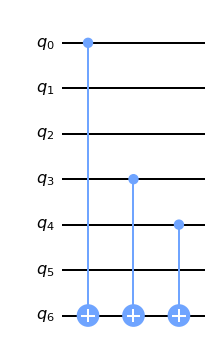

In [3]:
circuit_uf = QuantumCircuit(n + 1, name = "  Oracle Uf  ")

# Añadimos puertas CNOT
s_inv = s[::-1]
for i in range(n):
    if s_inv[i] != '0':
        circuit_uf.cnot(i, n)
        
circuit_uf.draw('mpl')

Convertimos nuestro subcircuito en una caja negra, que será la que usaremos en el circuito definitivo.

In [4]:
Uf = circuit_uf.to_instruction()

Ahora, seguimos el algoritmo descrito arriba para construir el circuito que encuentra $s$.

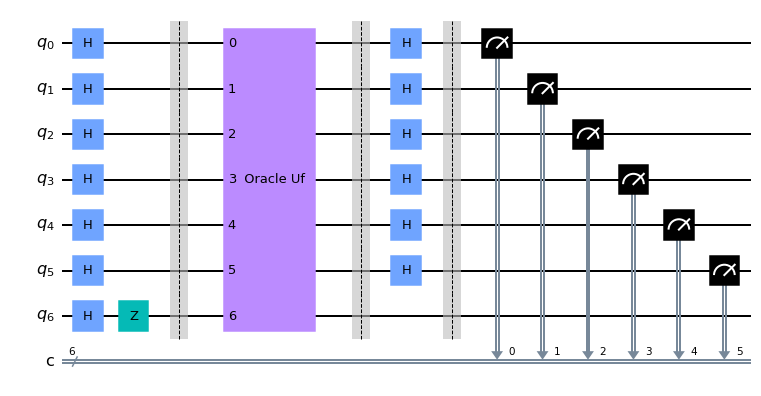

In [7]:
# Construimos un circuito con n+1 qubits
q = QuantumRegister(n + 1, 'q')
c = ClassicalRegister(n, 'c')
circuit = QuantumCircuit(n + 1, n)

# Aplicamos H a todos los qubits
circuit.h(q)
circuit.z(q[n])
circuit.barrier()

# Añadimos el oráculo U_f
circuit.append(Uf, range(n+1))
circuit.barrier()

# Aplicamos H de nuevo
circuit.h(q[0:n])
circuit.barrier()

# Añadimos mediciones a todo excepto al bit de signo
circuit.measure(q[0:n], c[0:n])

circuit.draw('mpl')

Finalmente, ejecutamos el algoritmo y vemos como siempre encuentra el valor de $s$.

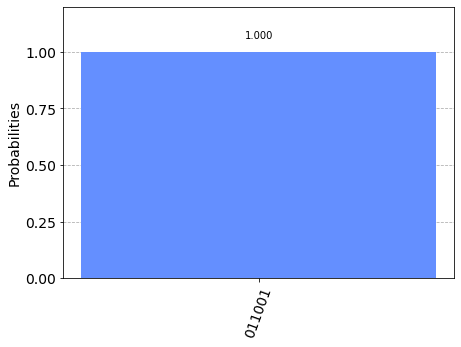

In [8]:
backend = provider.get_backend('ibmq_qasm_simulator')
counts = execute(circuit, backend, shots=1024).result().get_counts(circuit)
plot_histogram(counts)